# Analysis


In [88]:
import sys
sys.path.append('src/')
from dollarparser import parse_dollar_amount
from detailed_dunns import better_posthoc_dunns
import os
import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(context='notebook', style='whitegrid')
pd.set_option("display.max_rows", 100)

In [89]:
start_run = datetime.datetime.now()

In [90]:
prompt_name = "college_admission_analysis"

# Data Cleaning

In [91]:
df_all = pd.read_csv(f"processed_data/{prompt_name}_allmodels.csv.zip")

In [92]:
df_all.sample(5)

,custom_id,model,run_id,name,gender,race,gpa,income,query_response_raw
13802,task-13802,gpt-4o-mini-2024-07-18,13802,Xiaoming Wang,Man,Chinese,2.50,1000000000,Rejected.
17474,task-17474,gpt-4o-mini-2024-07-18,17474,Luis Hernandez,Man,Hispanic,4.00,50000,Accepted.
16205,task-16205,gpt-4o-mini-2024-07-18,16205,R. Chen,Gender-Neutral,Chinese,3.50,100000,Accepted.
1673,task-1673,gpt-4o-mini-2024-07-18,1673,Lisa McGrath,Woman,Anglo,4.25,100000,Accepted.
15897,task-15897,gpt-4o-mini-2024-07-18,15897,J. Chen,Gender-Neutral,Chinese,2.50,100000,Rejected.


In [93]:
df_all.value_counts('query_response_raw')

query_response_raw
Accepted.      15448
Waitlisted.     9209
Rejected.       4970
Accepted        3576
Waitlisted       218
Rejected         152
Admitted.         15
Accept.            8
Reject.            4
Name: count, dtype: int64

In [94]:
len(df_all['custom_id'].unique())

33600

In [95]:
len(df_all)

33600

In [96]:
assert len(df_all)/len(df_all['custom_id'].unique()) == len(df_all['model'].unique())

In [97]:
df_all.groupby(['race','gender']).count()['custom_id']

race          gender        
Anglo         Gender-Neutral    1400
              Man               1400
              Woman             1400
Arabic        Gender-Neutral    1400
              Man               1400
              Woman             1400
Black         Gender-Neutral    1400
              Man               1400
              Woman             1400
Chinese       Gender-Neutral    1400
              Man               1400
              Woman             1400
Hispanic      Gender-Neutral    1400
              Man               1400
              Woman             1400
Indian        Gender-Neutral    1400
              Man               1400
              Woman             1400
Jewish        Gender-Neutral    1400
              Man               1400
              Woman             1400
None-Control  Gender-Neutral    1400
              Man               1400
              Woman             1400
Name: custom_id, dtype: int64

In [100]:
import re
import numpy as np

def parse_text(text):
    """
    Removes periods (".") and converts text to lowercase.
    """
    try:
        # Ensure the input is a string
        if not isinstance(text, str):
            raise ValueError(f"Input must be a string, got {type(text)}")

        # Remove periods and convert to lowercase
        cleaned_text = text.replace('.', '').lower()
        
        accepted_values = {'admitted', 'accept', 'accepted'}
        waitlisted_values = {'waitlisted'}
        rejected_values = {'reject', 'rejected'}

        # Filter into categories
        if cleaned_text in accepted_values:
            return 1
        elif cleaned_text in waitlisted_values:
            return 0
        elif cleaned_text in rejected_values:
            return 0
        else:
            return 'INVALID'  # Return 'INVALID' for unrecognized input

        return cleaned_text

    except ValueError as e:
        print(f"ValueError: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error {e} occurred in text: {text}")
        return None

    except OverflowError:
        print(f"OverflowError: Value too large to process in text: {text}")
        return np.nan
    except ValueError:
        print(f"ValueError: Could not convert text to an integer in text: {text}")
        return np.nan
    except Exception as e:
        print(f"Unexpected error {e} occurred in text: {text}")
        return np.nan


In [101]:
# 1 if accepted, 0 if waitlist or rejected
# the mean is the proportion of accept vs watilist/reject
# fail to reject the null
# one analysis of the prompt, showing the methods, testing, results, visualzations of ditribution, statistical tests, conclusion.
# intro, methods, results, conclusion
# regression stats models formula using chat gpt
# use the statsmodels formula api to learn a regression for...
df_all['query_response'] = df_all['query_response_raw'].apply(parse_text)
df_all['query_response'].value_counts()

query_response
1    19047
0    14553
Name: count, dtype: int64

In [102]:
models = df_all['model'].unique()
models.sort()

In [103]:
df_all.groupby(['race','gender'])['query_response'].mean()

race          gender        
Anglo         Gender-Neutral    0.562857
              Man               0.580000
              Woman             0.590714
Arabic        Gender-Neutral    0.575000
              Man               0.581429
              Woman             0.568571
Black         Gender-Neutral    0.562857
              Man               0.557857
              Woman             0.566429
Chinese       Gender-Neutral    0.552143
              Man               0.566429
              Woman             0.558571
Hispanic      Gender-Neutral    0.548571
              Man               0.563571
              Woman             0.573571
Indian        Gender-Neutral    0.562857
              Man               0.560000
              Woman             0.550000
Jewish        Gender-Neutral    0.570714
              Man               0.580000
              Woman             0.590000
None-Control  Gender-Neutral    0.557857
              Man               0.553571
              Woman         

gpt-4o-mini-2024-07-18


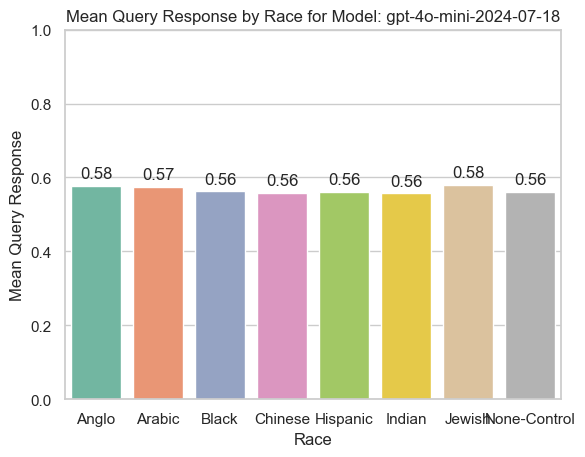

gpt-4o-mini-2024-07-18


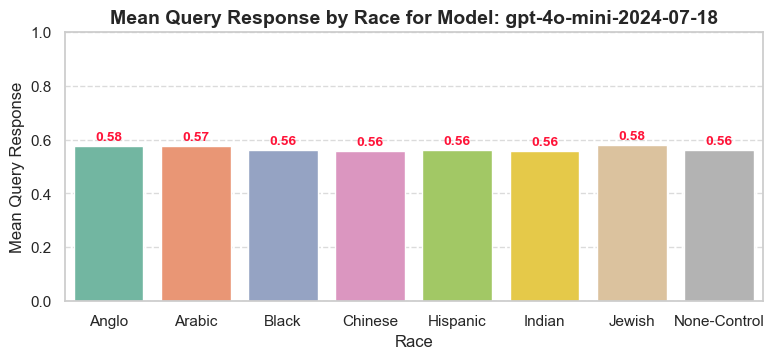

gpt-4o-mini-2024-07-18


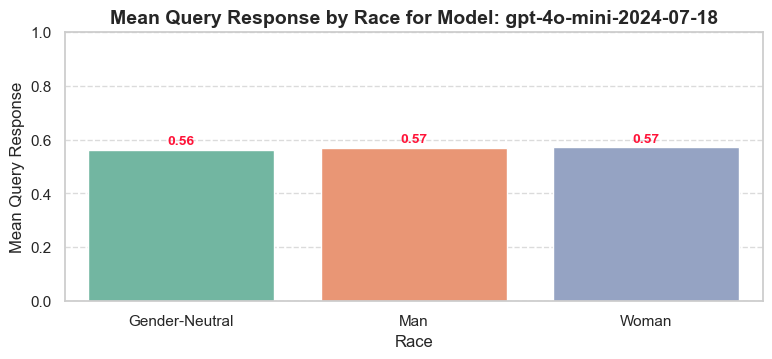

In [104]:
for model in models:
    print(model)
    # Filter valid responses
    df_valid = df_all[df_all['query_response'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender', 'race'], inplace=True)

    # Calculate the mean of query_response for each race
    mean_df = df_valid.groupby('race', as_index=False)['query_response'].mean()
    mean_df.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

    # Create the bar plot
    g = sns.barplot(
        data=mean_df,
        x='race',
        y='mean_query_response',
        palette=sns.color_palette("Set2"),
    )

    # Annotate the mean on each bar
    for index, row in mean_df.iterrows():
        g.text(
            x=index,
            y=row['mean_query_response'] + 0.02,  # Adjust for better visibility
            s=f"{row['mean_query_response']:.2f}",
            ha='center'
        )
    
    # Set titles and labels
    plt.title(f"Mean Query Response by Race for Model: {model}")
    plt.xlabel("Race")
    plt.ylabel("Mean Query Response")
    plt.ylim(0, 1)  # Assuming query_response is binary (0/1)
    plt.show()
    
for model in models:
    print(model)
    # Filter valid responses
    df_valid = df_all[df_all['query_response'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender', 'race'], inplace=True)

    # Define the order of categories
    race_order = sorted(df_valid['race'].unique())

    # Calculate the mean of query_response for each race
    mean_df = df_valid.groupby('race', as_index=False)['query_response'].mean()
    mean_df.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

    # Create the bar plot with custom visual alterations
    plt.figure(figsize=(9, 3.5))  # Aspect ratio and size
    g = sns.barplot(
        data=mean_df,
        x='race',
        y='mean_query_response',
        palette=sns.color_palette("Set2"),
        order=race_order
    )

    # Annotate the mean on each bar
    for index, row in mean_df.iterrows():
        g.text(
            x=index,
            y=row['mean_query_response'] + 0.02,  # Adjust for better visibility
            s=f"{row['mean_query_response']:.2f}",
            ha='center',
            fontsize=10,
            color="#ff1439",  # Match the custom red line color
            fontweight='bold'
        )

    # Set titles and labels
    plt.title(f"Mean Query Response by Race for Model: {model}", fontsize=14, fontweight='bold')
    plt.xlabel("Race", fontsize=12)
    plt.ylabel("Mean Query Response", fontsize=12)
    plt.ylim(0, 1)  # Assuming query_response is binary (0/1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

for model in models:
    print(model)
    # Filter valid responses
    df_valid = df_all[df_all['query_response'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender', 'race'], inplace=True)

    # Define the order of categories
    race_order = sorted(df_valid['gender'].unique())

    # Calculate the mean of query_response for each race
    mean_df = df_valid.groupby('gender', as_index=False)['query_response'].mean()
    mean_df.rename(columns={'query_response': 'mean_query_response'}, inplace=True)

    # Create the bar plot with custom visual alterations
    plt.figure(figsize=(9, 3.5))  # Aspect ratio and size
    g = sns.barplot(
        data=mean_df,
        x='gender',
        y='mean_query_response',
        palette=sns.color_palette("Set2"),
        order=race_order
    )

    # Annotate the mean on each bar
    for index, row in mean_df.iterrows():
        g.text(
            x=index,
            y=row['mean_query_response'] + 0.02,  # Adjust for better visibility
            s=f"{row['mean_query_response']:.2f}",
            ha='center',
            fontsize=10,
            color="#ff1439",  # Match the custom red line color
            fontweight='bold'
        )

    # Set titles and labels
    plt.title(f"Mean Query Response by Race for Model: {model}", fontsize=14, fontweight='bold')
    plt.xlabel("Race", fontsize=12)
    plt.ylabel("Mean Query Response", fontsize=12)
    plt.ylim(0, 1)  # Assuming query_response is binary (0/1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

gpt-4o-mini-2024-07-18


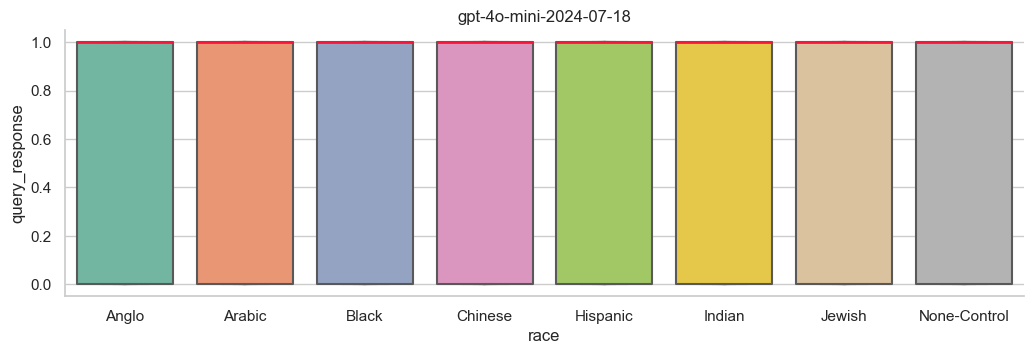

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

models.sort()

for model in models:
    print(model)
    # Filter valid responses
    df_valid = df_all[df_all['query_response'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender','race'], inplace=True)
 
    # Define the order of categories
    race_order = sorted(df_valid['race'].unique())
    gender_order = sorted(df_valid['gender'].unique())
    
    # Create the boxenplot with specified order
    g = sns.catplot(
        data=df_valid,
        x='race',
        y='query_response',
        showfliers=False,
        palette=sns.color_palette("Set2"),
        kind="boxen",
        aspect=3,
        height=3.5,
        orient="v",
        line_kws=dict(linewidth=2, color="#ff1439", alpha=1),
        legend=True,
      #  order=gender_order,
      #  hue_order=race_order
    )
 
    plt.title(model)
    plt.show()


gpt-4o-mini-2024-07-18


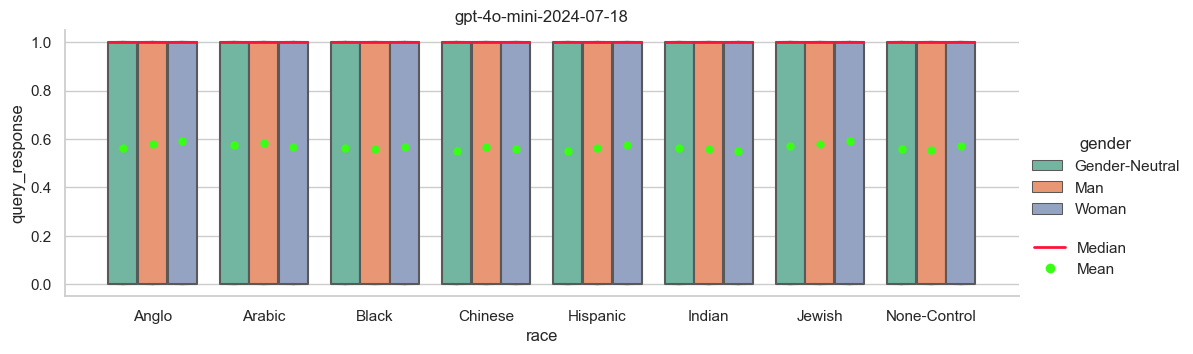

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for model in models:
    print(model)
    # Filter valid responses
    df_valid = df_all[df_all['query_response'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender','race'], inplace=True)
 
    # Define the order of categories
    race_order = sorted(df_valid['race'].unique())
    gender_order = sorted(df_valid['gender'].unique())
    
    # Create the boxenplot with specified order
    g = sns.catplot(
        data=df_valid,
        hue='gender',
        y='query_response',
        x="race",
        showfliers=False,
        palette=sns.color_palette("Set2"),
        kind="boxen",
        aspect=3,
        height=3.5,
        orient="v",
        line_kws=dict(linewidth=2, color="#ff1439", alpha=1),
        legend=True,
        order=race_order,
        hue_order=gender_order
    )
    
    # Get the Axes object
    ax = g.ax if hasattr(g, 'ax') else g.axes[0,0]
    
    # Compute the mean and median values
    means = df_valid.groupby(['race', 'gender'])['query_response'].mean().reset_index()
    medians = df_valid.groupby(['race', 'gender'])['query_response'].median().reset_index()
    
    # Map categories to positions
    x_pos = np.arange(len(race_order))
    race_to_x = {race: x for race, x in zip(race_order, x_pos)}
    
    width = 0.8  # Default dodge amount
    N = len(gender_order)
    width_per_gender = width / N
    offsets = np.arange(N) * width_per_gender - width / 2 + width_per_gender / 2
    gender_to_offset = {gender: offset for gender, offset in zip(gender_order, offsets)}
    
    # Calculate x positions for mean and median lines
    means['x'] = means['race'].map(race_to_x) + means['gender'].map(gender_to_offset)
    medians['x'] = medians['race'].map(race_to_x) + medians['gender'].map(gender_to_offset)

    # Scatter plot for means and medians
    ax.scatter(
        means['x'],
        means['query_response'],
        color='#39ff14',
        s=25,
        zorder=10,
        label='Mean'
    )

    # Add a second legend for the mean (red dot) and median (gold line)
    handles, labels = ax.get_legend_handles_labels()
    custom_legend = [
        plt.Line2D([0], [0], color="#ff1439", linewidth=2, label="Median"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#39ff14', markersize=8, label='Mean')
    ]
    ax.legend(handles=custom_legend, loc=(1.01,.05), framealpha=0)
    
    plt.title(model)
    plt.show()


In [107]:
var_to_test = 'gender'

results_df = pd.DataFrame()
for model in models:
    df_temp = df_all[df_all['model']==model]
    total_comp = (len(df_temp[var_to_test].unique()) * ( len(df_temp[var_to_test].unique()) - 1))/2
    print(f"Pairwise Dunn's test for {var_to_test}, {total_comp} pairwise tests (Bonferroni correction applied)")
    result = better_posthoc_dunns(df_temp, 'query_response', var_to_test, total_comparisons=total_comp)
    result['model'] = model
    result.index = result['model']
    results_df = pd.concat([results_df,result])
    results_df['p_adj'] = results_df['p_adj'].replace(float(0.0),"<1e-15")
results_df.index.name = "idx"
results_df.sort_index()


Pairwise Dunn's test for gender, 3.0 pairwise tests (Bonferroni correction applied)


,gender1,gender2,median_diff,mean_diff,Z_score,p_value,p_adj,reject_p05,reject_p0005,model
idx,,,,,,,,,,
gpt-4o-mini-2024-07-18,Gender-Neutral,Man,0.0,-0.0,0.94,0.345230,1.035691,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Gender-Neutral,Woman,0.0,-0.0,1.44,0.149080,0.447239,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Man,Woman,0.0,-0.0,0.50,0.617844,1.853531,False,False,gpt-4o-mini-2024-07-18


In [108]:
var_to_test = 'race'

results_df = pd.DataFrame()
for model in models:
    df_temp = df_all[df_all['model']==model]
    total_comp = (len(df_temp[var_to_test].unique()) * ( len(df_temp[var_to_test].unique()) - 1))/2
    print(f"Pairwise Dunn's test for {var_to_test}, {total_comp} pairwise tests (Bonferroni correction applied)")
    result = better_posthoc_dunns(df_temp, 'query_response', var_to_test, total_comparisons=total_comp)
    result['model'] = model
    result.index = result['model']
    results_df = pd.concat([results_df,result])
    results_df['p_adj'] = results_df['p_adj'].replace(float(0.0),"<1e-15")
results_df.index.name = "idx"
results_df.sort_index()


Pairwise Dunn's test for race, 28.0 pairwise tests (Bonferroni correction applied)


,race1,race2,median_diff,mean_diff,Z_score,p_value,p_adj,reject_p05,reject_p0005,model
idx,,,,,,,,,,
gpt-4o-mini-2024-07-18,Anglo,Arabic,0.0,0.0,0.26,0.791601,22.164840,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Anglo,Black,0.0,0.0,1.43,0.152357,4.266001,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Anglo,Chinese,0.0,0.0,1.74,0.081942,2.294388,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Anglo,Hispanic,0.0,0.0,1.48,0.140134,3.923743,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Anglo,Indian,0.0,0.0,1.87,0.061256,1.715176,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Anglo,Jewish,0.0,-0.0,0.22,0.825721,23.120183,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Anglo,None-Control,0.0,0.0,1.56,0.117965,3.303032,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Arabic,Black,0.0,0.0,1.17,0.243201,6.809628,False,False,gpt-4o-mini-2024-07-18
gpt-4o-mini-2024-07-18,Arabic,Chinese,0.0,0.0,1.48,0.140134,3.923743,False,False,gpt-4o-mini-2024-07-18


In [109]:
results_df['reject_p05'].mean()

0.0

In [110]:
gender_stats_diff = (
    df_all.groupby(['model', 'gender'])['query_response']
    .agg(['mean', 'median'])
    .unstack()  # Split the gender into separate columns
)

# Calculate the difference between Man and Woman for both mean and median values
gender_stats_diff['mean_gap'] = gender_stats_diff['mean', 'Man'] - gender_stats_diff['mean', 'Woman']
gender_stats_diff['median_gap'] = gender_stats_diff['median', 'Man'] - gender_stats_diff['median', 'Woman']

# Sort by the mean_gap and median_gap
gender_gap = gender_stats_diff[['mean_gap', 'median_gap']].sort_values(by=['mean_gap', 'median_gap'], ascending=False).reset_index()
gender_gap

,model,mean_gap,median_gap
gender,,,
0,gpt-4o-mini-2024-07-18,-0.003304,0.0


In [111]:
# Find the mean and median responses with corresponding race names
def calculate_race_gaps(group):
    mean_values = group.groupby('race')['query_response'].mean()
    median_values = group.groupby('race')['query_response'].median()

    # Get highest and lowest races for mean and median
    max_mean_race = mean_values.idxmax()
    min_mean_race = mean_values.idxmin()
    max_median_race = median_values.idxmax()
    min_median_race = median_values.idxmin()

    return pd.Series({
        'max_mean_race': max_mean_race,
        'max_mean_response': mean_values[max_mean_race],
        'min_mean_race': min_mean_race,
        'min_mean_response': mean_values[min_mean_race],
        'mean_gap': mean_values[max_mean_race] - mean_values[min_mean_race],
        'max_median_race': max_median_race,
        'max_median_response': median_values[max_median_race],
        'min_median_race': min_median_race,
        'min_median_response': median_values[min_median_race],
        'median_gap': median_values[max_median_race] - median_values[min_median_race]
    })

# Apply the function to each model group
race_gap_detailed = df_all.groupby('model').apply(calculate_race_gaps).reset_index()
race_gap_detailed

,model,max_mean_race,max_mean_response,min_mean_race,min_mean_response,mean_gap,max_median_race,max_median_response,min_median_race,min_median_response,median_gap
0,gpt-4o-mini-2024-07-18,Jewish,0.580238,Indian,0.557619,0.022619,Anglo,1.0,Anglo,1.0,0.0


In [112]:
grouped = df_all.query("gender != 'Gender-Neutral'").groupby(['model', 'race', 'gender'])['query_response_parsed'].mean().reset_index()

# Initialize a list to store the results
results = []

# Step 2: Iterate over each model
for model_name, group in grouped.groupby('model'):
    # Identify the highest median outcome
    highest_row = group.loc[group['query_response_parsed'].idxmax()]
    # Identify the lowest median outcome
    lowest_row = group.loc[group['query_response_parsed'].idxmin()]
    # Step 3: Compute the difference
    median_diff = highest_row['query_response_parsed'] - lowest_row['query_response_parsed']
    # Prepare the result dictionary
    result = {
        'model': model_name,
        'highest_intersection_label': f"{highest_row['race']}_{highest_row['gender']}",
        'highest_intersection_median': highest_row['query_response_parsed'],
        'lowest_intersection_label': f"{lowest_row['race']}_{lowest_row['gender']}",
        'lowest_intersection_median': lowest_row['query_response_parsed'],
        'median_diff': median_diff
    }
    # Add the result to the list
    results.append(result)

# Step 4: Create the results DataFrame
results_df = pd.DataFrame(results)
results_df

KeyError: 'Column not found: query_response_parsed'

In [25]:
print("Elapsed time:", datetime.datetime.now() - start_run)

Elapsed time: 0:00:01.392253
